In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [3]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
    
(2, 'Developed Land'),   
#(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
  
(6, 'Agricultural Land'),
#(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
    
(8, 'Grassland'),
    
(9, 'Forest Land'),
#(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
    
(12, 'Scrub/Shrub'),
    
(20, 'Barren Land'),
#(20, 'Bare Land'),
(24, 'Tundra'),
(25, 'Snow/Ice'),
    
(13, 'Palustrine Wetlands'),    
#(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
    
(16, 'Estuarine Wetlands'),
#(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
    
(19, 'Unconsolidated Shore'),

(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed')

))

def change_label_image(label_image):
    label_image[label_image == 255] = 1
    label_image[label_image == 3] = 2
    label_image[label_image == 4] = 2
    label_image[label_image == 5] = 2

    label_image[label_image == 7] = 6

    label_image[label_image == 10] = 9
    label_image[label_image == 11] = 9
    
    label_image[label_image == 24] = 20
    label_image[label_image == 25] = 20

    label_image[label_image == 14] = 13 
    label_image[label_image == 15] = 13
    
    label_image[label_image == 17] = 16
    label_image[label_image == 18] = 16
    
    label_image[label_image == 22] = 21
    label_image[label_image == 23] = 21
    
    
    return label_image

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

"""
TO Run: 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()
"""


'\nTO Run: \n\nnp.set_printoptions(precision=2)\n\n# Plot non-normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names)\n\n# Plot normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names,\n                      normalize=True)\n\nplt.show()\n'

In [4]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [35]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    
    #label_image = label_dataset.read()
    #label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    #class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,23))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,[4,3,2]]
                    b += 1
        yield (image_batch, label_batch)
        
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [22]:
def plot_predictions(model, tilesz):
    test_px, _ = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=500, tile_size=tilesz)
    predictions = model.predict_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)
    eval_generator = tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, test_px, batch_size=1)
    labels = np.empty(predictions.shape)
    count = 0
    while count < len(test_px):
        image_b, label_b = next(eval_generator)
        labels[count] = label_b
        count += 1
    
    label_index = np.argmax(labels, axis=1)     
    pred_index = np.argmax(predictions, axis=1)

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

    # Plot normalized confusion matrix
    plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [6]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [11]:
batch_size = 25
label_image = label_dataset.read()
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
label_image = change_label_image(label_image)

epochs = 50


weight_decay = 0.01

print(num_classes)

23


In [10]:
print(len(np.unique(label_image)))

12


In [12]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg19 import VGG19

In [13]:
from keras.optimizers import SGD

In [32]:


# vgg16 min height is 32
def vgg16_fine_tune(tilesz=32):
    train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=500, tile_size=tilesz)
    vgg16_model = VGG16(weights='imagenet', include_top=False)
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(23, activation='softmax')(x)

    model = Model(inputs=vgg16_model.input, outputs=predictions)
    for layer in vgg16_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size,epochs=10)

    for i, layer in enumerate(model.layers):

        if i < 15:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    history =     model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                                      epochs=50,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, shuffle=True)
    return history


# vgg19
def vgg19_fine_tune(tilesz=32):
    train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=500, tile_size=tilesz)
    vgg19_model = VGG19(weights='imagenet', include_top=False)
    x = vgg19_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(23, activation='softmax')(x)

    model = Model(inputs=vgg19_model.input, outputs=predictions)
    for layer in vgg19_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size,epochs=10)
    for i, layer in enumerate(model.layers):

        if i < 17:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                                      epochs=50,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, shuffle=True)
    return history


# inception_v3
def inception_fine_tune(tilesz=75):
    train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                      train_count=5000, val_count=500, tile_size=tilesz)
    inception_model = InceptionV3(weights='imagenet', include_top=False)
    x = inception_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(23, activation='softmax')(x)

    model = Model(inputs=inception_model.input, outputs=predictions)
    for layer in inception_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size,epochs=10)
    for i, layer in enumerate(model.layers):

        if i < 249:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                                      epochs=50,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, shuffle=True)
    return history

# xception
def xception_fine_tune(tilesz=71):
    train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=500, tile_size=tilesz)
    xception_model = Xception(weights='imagenet', include_top=False)
    x = xception_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(23, activation='softmax')(x)

    model = Model(inputs=xception_model.input, outputs=predictions)
    for layer in xception_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size,epochs=10)
    for i, layer in enumerate(model.layers):

        if i < 115:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, verbose=1,
                                      epochs=50,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tilesz, tilesz, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, shuffle=True)
    return history

In [17]:
vgg16model = vgg16_fine_tune()

100%|██████████| 4/4 [00:59<00:00, 14.71s/it]


Epoch 1/32
200/200 [==============================] - 15s 73ms/step - loss: 2.1793 - acc: 0.2892 - val_loss: 2.0391 - val_acc: 0.3320
Epoch 2/32
200/200 [==============================] - 7s 36ms/step - loss: 2.0345 - acc: 0.3252 - val_loss: 2.0624 - val_acc: 0.3240
Epoch 3/32
200/200 [==============================] - 7s 34ms/step - loss: 1.9943 - acc: 0.3430 - val_loss: 2.0120 - val_acc: 0.3520
Epoch 4/32
200/200 [==============================] - 7s 33ms/step - loss: 1.9582 - acc: 0.3562 - val_loss: 2.0394 - val_acc: 0.3340
Epoch 5/32
200/200 [==============================] - 7s 35ms/step - loss: 1.9426 - acc: 0.3506 - val_loss: 2.0766 - val_acc: 0.3440
Epoch 6/32
200/200 [==============================] - 7s 34ms/step - loss: 1.9297 - acc: 0.3608 - val_loss: 1.9958 - val_acc: 0.3520
Epoch 7/32
200/200 [==============================] - 7s 33ms/step - loss: 1.9077 - acc: 0.3688 - val_loss: 2.0318 - val_acc: 0.3860
Epoch 8/32
200/200 [==============================] - 7s 34ms/step -

In [ ]:
vgg19model = vgg19_fine_tune()
inceptionmodel = inception_fine_tune()
xceptionmodel = xception_fine_tune()

In [36]:
inceptionmodel = inception_fine_tune()

100%|██████████| 4/4 [00:55<00:00, 14.02s/it]


Epoch 1/10
200/200 [==============================] - 30s 148ms/step - loss: 1.8061 - acc: 0.3172 - val_loss: 1.8782 - val_acc: 0.3460
Epoch 2/10
200/200 [==============================] - 12s 61ms/step - loss: 1.5320 - acc: 0.4144 - val_loss: 2.1313 - val_acc: 0.3400
Epoch 3/10
200/200 [==============================] - 13s 63ms/step - loss: 1.4160 - acc: 0.4656 - val_loss: 2.2847 - val_acc: 0.2660
Epoch 4/10
200/200 [==============================] - 12s 60ms/step - loss: 1.3673 - acc: 0.4820 - val_loss: 2.4560 - val_acc: 0.2980
Epoch 5/10
200/200 [==============================] - 12s 61ms/step - loss: 1.3487 - acc: 0.4944 - val_loss: 2.4567 - val_acc: 0.2860
Epoch 6/10
200/200 [==============================] - 12s 60ms/step - loss: 1.3135 - acc: 0.5006 - val_loss: 2.3315 - val_acc: 0.2340
Epoch 7/10
200/200 [==============================] - 12s 61ms/step - loss: 1.2841 - acc: 0.5254 - val_loss: 2.5191 - val_acc: 0.2860
Epoch 8/10
  5/200 [..............................] - ETA: 8s

KeyboardInterrupt: 

100%|██████████| 4/4 [00:57<00:00, 14.39s/it]


200/200 [==============================] - 18s 88ms/step


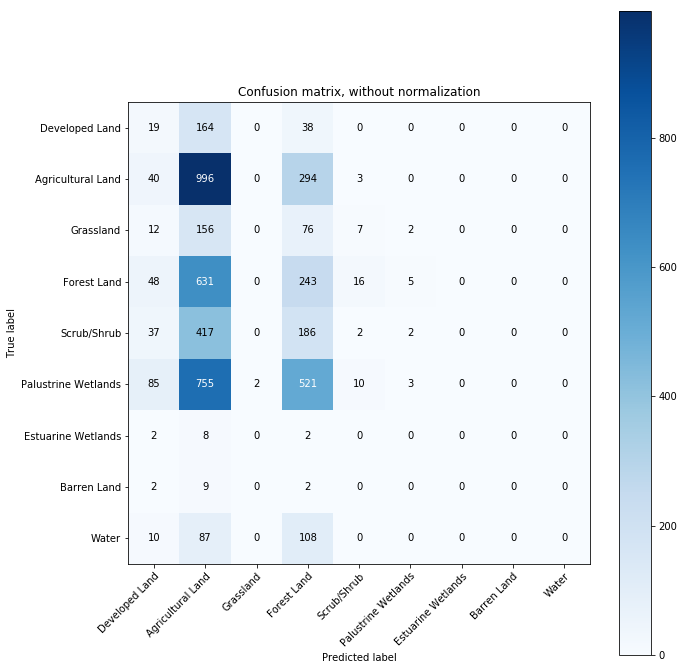

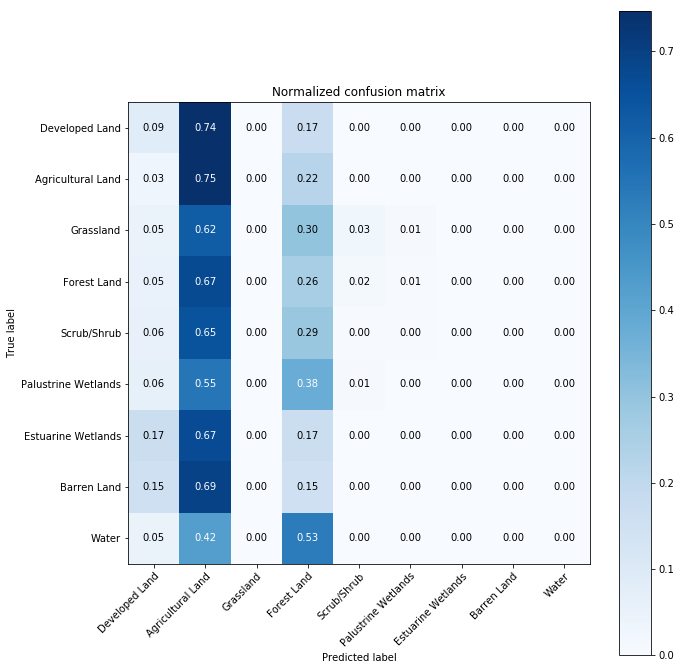

In [34]:
plot_predictions(inceptionmodel.model, 75)

In [27]:
np.unique(label_image)

array([ 0,  1,  2,  6,  8,  9, 12, 13, 16, 19, 20, 21], dtype=uint8)

In [24]:
inceptionmodel.model